In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'

# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import cartopy.io.shapereader as shpreader
matplotlib.rcParams.update({'font.size': 18, 'xtick.labelsize': 18})

In [2]:
results_filename = 'US_results_cleaned_data.csv'
results_filepath = 'plots/version2/tmax/'

In [26]:
# functions
# plotting 
# define functions used for plotting 

def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([])) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = 'None'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    cmap = matplotlib.cm.coolwarm
    c = data
    bounds = np.linspace(-1,1,11)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data
    plotHandle = ax.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                            c = c.values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.loc[c_insignificant.index]['Urban Lon'], paired_df.loc[c_insignificant.index]['Urban Lat'], 
        #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
            c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',linewidth = 4)

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

In [37]:
pairs = pd.read_csv('CleanedNovUSpairs_stationlengths.csv').drop(2)
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
paired_df = paired_df.set_index('City', drop=False).drop(['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ])

In [41]:
# Calculate the relationship between summertime  UHI and t_max, save it out for every city
#pairs = pd.read_csv('USghcnpairs_stationlengths.csv')
#paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# pre-allocate
#summertime
slopes           = np.ones(paired_df.shape[0])*np.nan
residuals        = np.ones(paired_df.shape[0])*np.nan
correlations     = np.ones(paired_df.shape[0])*np.nan
urban_start_date = np.ones(paired_df.shape[0])*np.nan
urban_end_date   = np.ones(paired_df.shape[0])*np.nan
rural_start_date = np.ones(paired_df.shape[0])*np.nan
rural_end_date   = np.ones(paired_df.shape[0])*np.nan
n_events         = np.ones(paired_df.shape[0])*np.nan
mean_rural_temp  = np.ones(paired_df.shape[0])*np.nan
mean_UHI         = np.ones(paired_df.shape[0])*np.nan
p_value          = np.ones(paired_df.shape[0])*np.nan
intercepts       = np.ones(paired_df.shape[0])*np.nan
max_UHI_day      = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan

#heatwave
hwslopes = np.zeros(paired_df.shape[0])
hwintercepts = np.zeros(paired_df.shape[0])
hwresiduals = np.zeros(paired_df.shape[0])
hwcorrelations = np.zeros(paired_df.shape[0])
hwp_value = np.zeros(paired_df.shape[0])
hwn_events = np.zeros(paired_df.shape[0])
hwmean_rural_temp = np.zeros(paired_df.shape[0])
hwmean_UHI = np.zeros(paired_df.shape[0])

#heatwave composite
composite_tmax = np.zeros([paired_df.shape[0], 11])
composite_UHImax = np.zeros([paired_df.shape[0], 11])

numhw = 150
finalhw = 50

Index([u'Unnamed: 0', u'Urban station', u'Urban Lat', u'Urban Lon',
       u'Urban brightness', u'Urban start', u'Urban end', u'Rural station',
       u'Rural Lat', u'Rural Lon', u'Rural brightness', u'Rural start',
       u'Rural end'],
      dtype='object')

In [42]:
# Summertime UHI and temperature
toc = time.time() #time
for i in range(20,21): # range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMAX' in urbandata.keys()) & ('TMAX' in ruraldata.keys()) & (np.intersect1d(urbandata['TMAX']['1985-01-01':].index, ruraldata['TMAX']['1985-01-01':].index).shape[0] > 300): 
        # Calculate maximum daily thresholds starting from 1985
        rural_tmax = pd.to_numeric(ruraldata['TMAX']['1985-01-01':].value/10.) #rural tmax
        urban_tmax = pd.to_numeric(urbandata['TMAX']['1985-01-01':].value/10.) 
        
        rural_start_date[i] = rural_tmax[~np.isnan(rural_tmax)].index[0].year
        rural_end_date[i]   = rural_tmax[~np.isnan(rural_tmax)].index[-1].year
        urban_start_date[i] = urban_tmax[~np.isnan(urban_tmax)].index[0].year
        urban_end_date[i]   = urban_tmax[~np.isnan(urban_tmax)].index[-1].year
               
        # extract summertime data 
        urban_summer = urban_tmax[(urban_tmax.index.month >= 6) & (urban_tmax.index.month <= 8)]
        rural_summer = rural_tmax[(rural_tmax.index.month >= 6) & (rural_tmax.index.month <= 8)]
        #calculate UHI
        UHI = urban_summer - rural_summer
        
        ######
        ###### Calculate heatwaves
        ######        
        hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
        minheatwaves = hottestmin[0:12]
        ### make sure that heatwaves aren't duplicates
        Ns = []
        m = 0 
        for n in range(1,10): 
            old = m
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                minheatwaves = hottestmin[0:20]
                try: 
                    while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(minheatwaves.sort_index().index[m])
                else: 
                    Ns.append(minheatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
        finalhw = hottestmin[Ns].sort_values(ascending=False)

#         # Save out the mean temperature and UHI
        try: 
#             mean_UHI[i] = UHI.mean()
#             max_UHI_day[i] = UHI.groupby(UHI.index.day_of_year).mean().argmax() # average yearly UHI cycle, and see which day has max UHI
#             mean_rural_temp[i] = rural_summer.mean()
#             #select available data points
#             clim = UHI.groupby(UHI.index.day_of_year).mean()
#             anomaly = UHI.values - (clim[UHI.index.day_of_year].values)
#             ind = ~np.isnan(anomaly)
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(np.arange(0,anomaly[ind].shape[0] ),anomaly[ind])
#             UHI_lin_trend[i] = slope
#             UHI_lin_trend_pvalue[i] = p

#             # define variables to analyze
#             #summertime
#             x = rural_summer
#             y = UHI
#             ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs

#             #heatwaves
#             hw_x = rural_summer[finalhw.index]#[np.logical_or(rural_tmax.index.month==6, rural_tmax.index.month==7, rural_tmax.index.month==8)] 
#             hw_y = UHI[finalhw.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
#             hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs

#             # plot summertime temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(x[ind],y[ind],'%s JJA $T_r$ vs. $\Delta T$ (max)'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'JJAUHI%s%s.png'%(city.replace(" ", "")[0:5], 'max'))
#             plt.close()

#             # plot heatwave temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(hw_x[hw_ind],hw_y[hw_ind],'%s Heatwave $T_r$ vs. $\Delta T$ (max)'%city, 'HW Rural Temp ($^\circ$C)', 'HW UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'max'))
#             plt.close()

#             # plot composite heatwave events
            heatwaves = finalhw#maxheatwaves[-10:]
            compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
            compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
            ii = 0
            for dates in heatwaves.index[:]: 
                try: 
                    compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                    compositeTemp[ii,:]= rural_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                except: 
                    'skipping'#print 'skipping %s'%dates#compositeUHI2[ii,:] = (UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values -UHI[dates.to_timestamp()])/UHI[dates.to_timestamp()-pd.DateOffset(days=5)]
                ii = ii+1
#             plt.figure(figsize=[12,4])
#             plt.subplot(1,2,1)
#             tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
#             plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
#             plt.title('Max %s Temp'%(city))
#             plt.ylabel('Temp. ($^\circ C$)')
#             plt.xlabel('Heatwave Day')

#             plt.subplot(1,2,2)    
#             uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
#             plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
#             plt.title('Max %s UHI'%(city))
#             plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
#             plt.xlabel('Heatwave Day')
#             plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
#             plt.savefig(results_filepath+'max'+'hwcomposite%s'%city.replace(" ", "")[0:5]+'.png')        # save out 
#             plt.close()
#             composite_tmax[i,:] = np.nanmean(compositeTemp, axis=0)
#             composite_UHImax[i,:] = np.nanmean(compositeUHI, axis=0)
#             # save out data
#             # first, save out summertime 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
#             #V = np.polyfit(x[ind],y[ind],1, full = True)
#             C = pearsonr_autocorrelated(x[ind], y[ind])
#             slopes[i] = slope #V[0][0]
#             intercepts[i] = intercept
#             residuals[i] = std_err#V[1][0]
#             correlations[i] = r_value#C[0]#np.corrcoef(x[ind],y[ind])[0,1]
#             p_value[i] = C[1]
#             n_events[i] = ind.values.sum()
            
#             # second, heatwaves 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(hw_x[hw_ind],hw_y[hw_ind])
#             hwslopes[i] = slope
#             hwintercepts[i] = intercept
#             hwresiduals[i] = std_err
#             hwcorrelations[i] = r_value
#             hwp_value[i] = p
#             hwn_events[i] = hw_ind.values.sum()
#             hwmean_rural_temp[i] = hw_x.mean()
#             hwmean_UHI[i] = hw_y.mean()
            
        except ValueError : 
            print 'ValueError'
#     #save out
#     if np.mod(i,10) == 0 : 
#         # summmertime
#         results_df = pd.DataFrame()
#         results_df['City']  = paired_df['City']
#         results_df['Slope'] = slopes
#         results_df['Intercepts'] = intercepts
#         results_df['Residual'] = residuals
#         results_df['Correlation'] = correlations
#         results_df['P-value'] = p_value
#         results_df['Urban start date'] = urban_start_date
#         results_df['Urban end date'] = urban_end_date
#         results_df['Rural start date'] = rural_start_date
#         results_df['Rural end date'] = rural_end_date
#         results_df['Data points'] = n_events
#         results_df['Mean UHI'] = mean_UHI
#         results_df['Day of Max UHI'] = max_UHI_day
#         results_df['Mean JJA Rural Temp'] = mean_rural_temp
#         results_df['UHI linear trend'] = UHI_lin_trend
#         results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue
#         # heatwaves
#         results_df['hw Slope'] = hwslopes
#         results_df['hw P-value'] = hwp_value
#         results_df['hw Residual'] = hwresiduals
#         results_df['hw Correlation'] = hwcorrelations
#         results_df['hw Data points'] = hwn_events
#         results_df['hw Mean UHI'] = hwmean_UHI
#         results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
#         # save out results
#         results_df.to_csv(results_filepath + results_filename)
#         # save out composite heatwave events
#         np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmax, delimiter = ',')
#         np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImax, delimiter = ',')

# #save out final data        
# results_df['City']  = paired_df['City']
# results_df['Slope'] = slopes
# results_df['Intercepts'] = intercepts
# results_df['Residual'] = residuals
# results_df['Correlation'] = correlations
# results_df['P-value'] = p_value
# results_df['Urban start date'] = urban_start_date
# results_df['Urban end date'] = urban_end_date
# results_df['Rural start date'] = rural_start_date
# results_df['Rural end date'] = rural_end_date
# results_df['Data points'] = n_events
# results_df['Mean UHI'] = mean_UHI
# results_df['Day of Max UHI'] = max_UHI_day
# results_df['Mean JJA Rural Temp'] = mean_rural_temp
# results_df['UHI linear trend'] = UHI_lin_trend
# results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue

# # heatwaves
# results_df['hw Slope'] = hwslopes
# results_df['hw P-value'] = hwp_value
# results_df['hw Residual'] = hwresiduals
# results_df['hw Correlation'] = hwcorrelations
# results_df['hw Data points'] = hwn_events
# results_df['hw Mean UHI'] = hwmean_UHI
# results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
# # save out results
# results_df.to_csv(results_filepath + results_filename)
# # save out composite heatwave events
# np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmax, delimiter = ',')
# np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImax, delimiter = ',')
                    
tic = time.time()
print('Elapsed time: ', tic-toc)

Baltimore
('Elapsed time: ', 204.78311586380005)


In [13]:
results_df.shape, paired_df.shape

((53, 23), (58, 14))

In [15]:
#pairs = pd.read_csv('USghcnpairs_stationlengths.csv')
#paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

drop_cities = ['Mesa','Long Beach', 'Virginia Beach']
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
results_df = pd.read_csv(results_filepath+ results_filename).set_index('City').loc[paired_df.index]
#results_df = results_df[results_df['Data points']>0].drop(drop_cities, axis = 0)

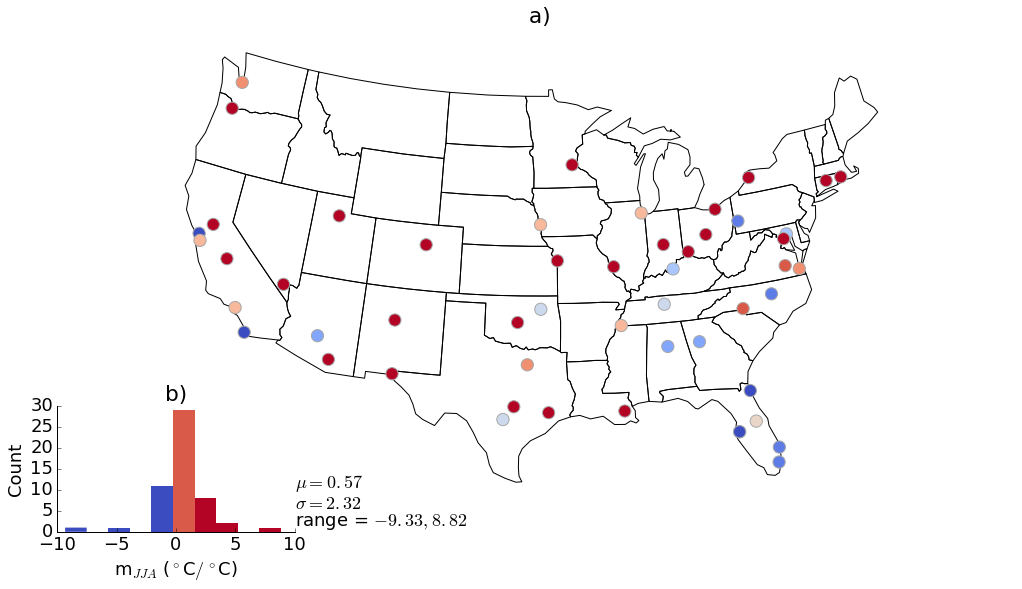

In [18]:
data = results_df['Mean UHI']

fig = map_hist_plot(data, paired_df, title = 'Mean $\Delta T_{max}$') 
plt.savefig(results_filepath+ 'meanTMAXUHI.pdf', bbox_inches='tight')

In [63]:
results_filepath

'plots/version2/tmax/'

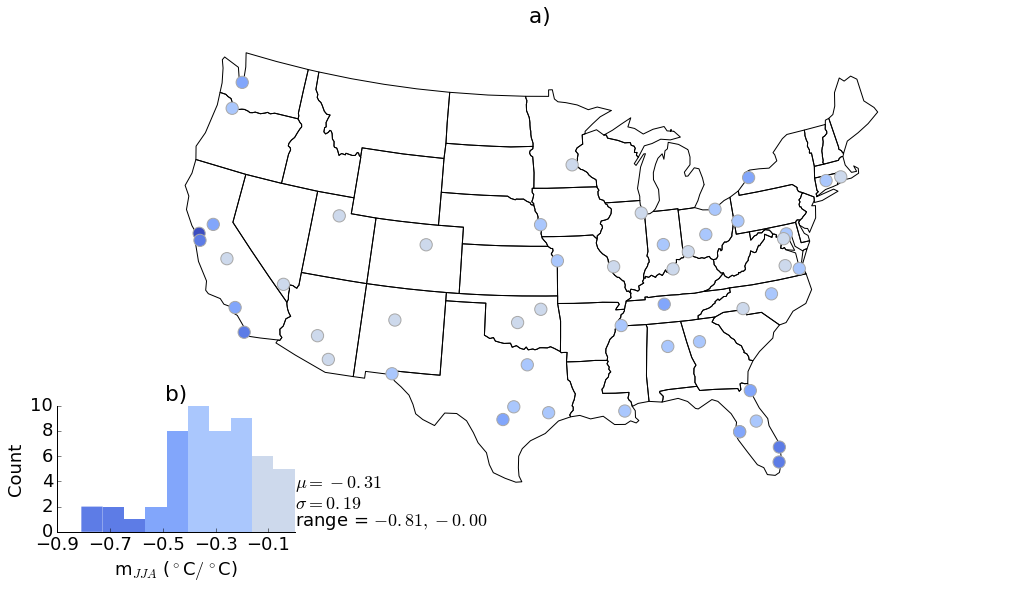

In [19]:
#drop_cities = ['Mesa','Long Beach', 'Virginia Beach', ]
data = results_df['Slope']#.drop(drop_cities, axis = 0)['Slope'] #slopes

fig = map_hist_plot(data, paired_df, title = 'Sensivity of $\Delta T_{max}$ to $T_{max}$') 
plt.savefig(results_filepath+ 'JJAslopesTMAX.pdf', bbox_inches='tight')

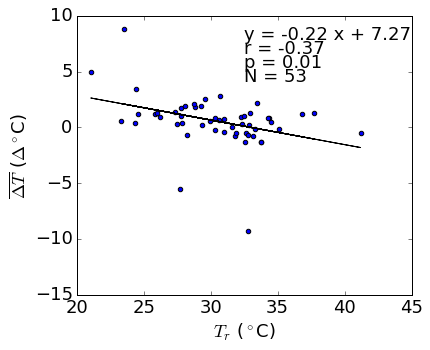

In [20]:
# plot mean summertime temp versus UHI
plt.figure(figsize=[6,5])
hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
             '', 
             '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($\Delta ^\circ$C)')
plt.savefig(results_filepath+ 'meantempvsmeanUHItmax.pdf',bbox_inches='tight')

In [44]:
results_df[results_df['Mean UHI'] < 0]

,Unnamed: 0,Slope,Intercepts,Residual,Correlation,P-value,Urban start date,Urban end date,Rural start date,Rural end date,...,Mean JJA Rural Temp,UHI linear trend,UHI linear trend p-value,hw Slope,hw P-value,hw Residual,hw Correlation,hw Data points,hw Mean UHI,hw Mean JJA Rural Temp
City,,,,,,,,,,,,,,,,,,,,,
Birmingham,6,-0.282869,8.769675,0.013850,-0.352977,1.915879e-69,1985.0,2016.0,1985.0,2016.0,...,32.666553,0.000119,1.471110e-02,8.237157e-01,0.597867,1.491180,2.043774e-01,9.0,-3.288889,40.377778
St. Petersburg,7,-0.475232,14.742186,0.013567,-0.546181,8.978175e-114,1985.0,2016.0,1985.0,2016.0,...,33.760873,0.000002,9.474617e-01,-7.858870e-01,0.046195,0.324950,-6.746953e-01,9.0,-4.988889,39.122222
Oakland,9,-0.808520,16.766688,0.012374,-0.788762,3.370829e-163,1985.0,2016.0,1985.0,2016.0,...,27.709694,0.000540,4.213987e-05,4.385910e-01,0.563960,0.718480,2.418162e-01,8.0,-15.850000,40.077778
West Palm Beach,10,-0.617426,19.588089,0.013941,-0.634618,3.751189e-202,1985.0,2016.0,1985.0,2016.0,...,32.797183,0.000319,9.581036e-18,7.103448e-01,0.273995,0.598508,4.092953e-01,9.0,-2.544444,36.488889
Louisville,11,-0.154607,4.400631,0.012675,-0.233377,1.795456e-22,1985.0,2016.0,1985.0,2016.0,...,30.963988,0.000810,9.946666e-52,2.139711e-01,0.839878,1.020391,7.900953e-02,9.0,-1.622222,39.755556
Tulsa,19,-0.127247,4.052287,0.008734,-0.262592,9.790514e-33,1985.0,2016.0,1985.0,2016.0,...,33.303138,0.000295,1.857120e-12,-1.553309e-01,0.490886,0.209055,-3.153336e-01,7.0,-1.214286,44.842857
Jacksonville,23,-0.480480,14.275997,0.015171,-0.519482,7.807291e-65,1985.0,2016.0,1985.0,2016.0,...,32.549154,0.000283,4.187185e-08,-2.823003e-15,1.000000,1.676892,-7.528723e-16,7.0,-7.100000,39.657143
Baltimore,26,-0.349408,10.368372,0.012986,-0.468535,9.671496e-91,1985.0,2016.0,1985.0,2016.0,...,30.337694,0.000653,3.481153e-17,-2.254835e-01,0.889999,1.572171,-5.412884e-02,9.0,-7.844444,42.277778
San Antonio,34,-0.498300,17.335545,0.012332,-0.611206,4.087880e-129,1985.0,2016.0,1985.0,2016.0,...,35.092336,-0.000239,1.266796e-04,-1.377025e+00,0.389045,1.499666,-3.278708e-01,9.0,-2.477778,41.188889


In [11]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

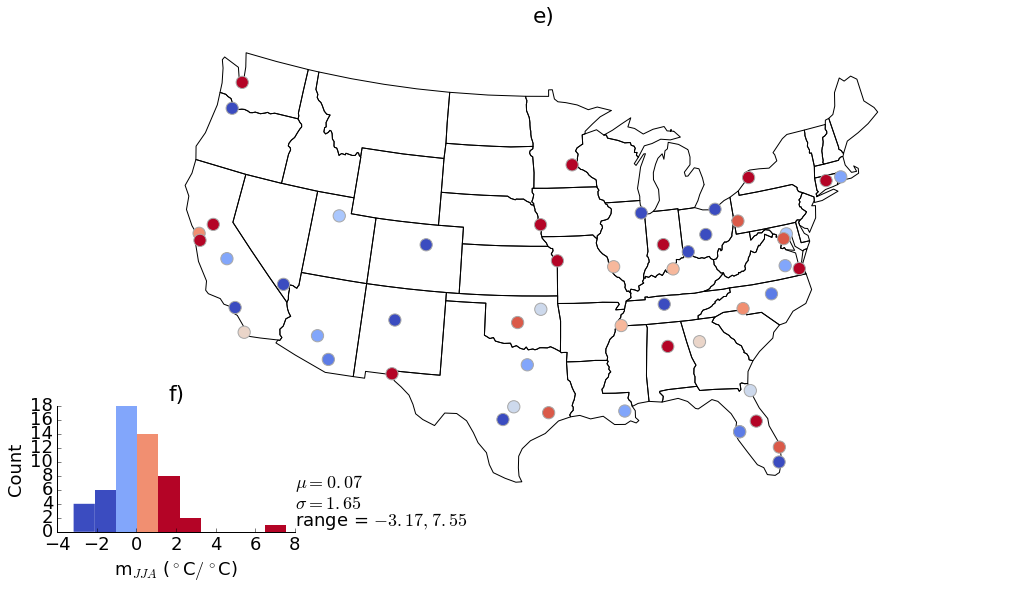

In [43]:
# Figure 2: heatwaves
data = results_df['hw Slope'] #slopes
fig, ax, sub_ax= map_hist_plot(data, paired_df, title = 'Response of Heatwave $\Delta T_{max}$ to $T_{max}$ Change', 
                   #c_insignificant =np.zeros(0),
) 

ax.set_title('e)')
sub_ax.set_title('f)')
plt.savefig(results_filepath+ 'HWslopesTMAX.pdf', bbox_inches='tight')

In [36]:
scipy.stats.mode(results_df['hw Slope'])

ModeResult(mode=array([-0.78588699]), count=array([2]))

In [37]:
-2.7/(39.0-33.2)

-0.4655172413793106

In [18]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [24]:
results_df[results_df['UHI linear trend p-value'] < 0.05].index

Index([u'Hartford', u'Providence', u'Birmingham', u'Oakland',
       u'West Palm Beach', u'Louisville', u'Tucson', u'Albuquerque', u'Tulsa',
       u'Austin', u'Orlando', u'Jacksonville', u'Indianapolis', u'Richmond',
       u'Baltimore', u'San Jose', u'Las Vegas', u'Portland', u'Salt Lake City',
       u'Omaha', u'Oklahoma City', u'San Antonio', u'Raleigh', u'Cleveland',
       u'Cincinnati', u'Norfolk', u'Minneapolis', u'Honolulu', u'Seattle',
       u'Phoenix', u'San Diego', u'St. Louis', u'New Orleans', u'Dallas',
       u'Houston', u'Miami', u'Atlanta', u'Chicago', u'Los Angeles',
       u'Washington, D.C.'],
      dtype='object', name=u'City')

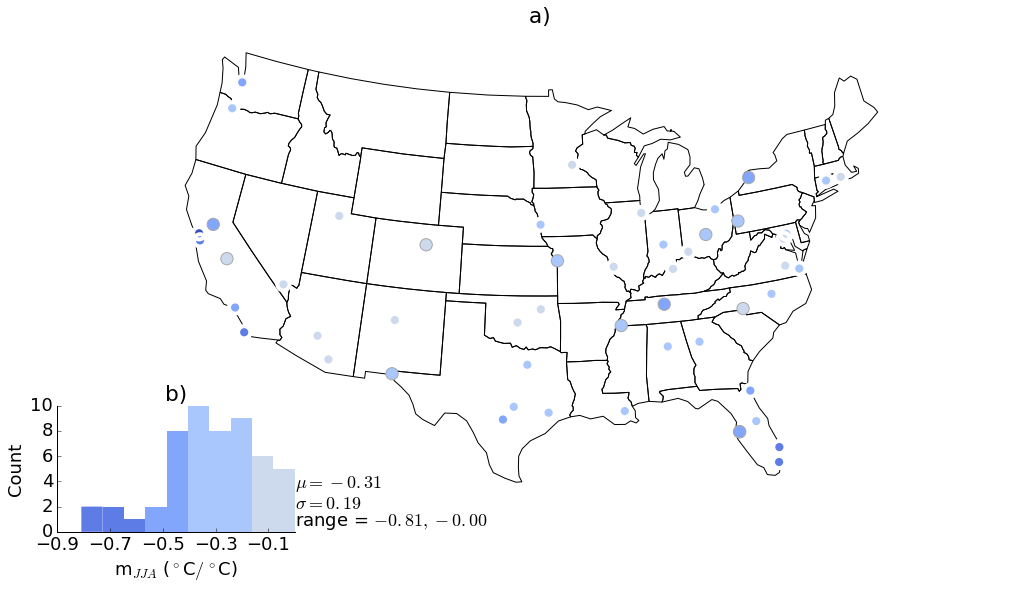

In [29]:
# Linear trend
data = results_df[~np.isnan(results_df['UHI linear trend'])].Slope
fig = map_hist_plot(data, paired_df, title = 'UHI linear trend', 
                   c_insignificant =results_df[results_df['UHI linear trend p-value'] < 0.05],
) 
plt.savefig(results_filepath+ 'UHIlinTrendTmax.pdf', bbox_inches='tight')

In [39]:
results_df[results_df['UHI linear trend p-value'] > 0.05].shape

(13, 23)

In [32]:
#results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df.index
# slopes_std = []
# for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
#     city = paired_df.iloc[i]['City']
#     if city == 'Grand Prairie': 
#         city = 'Arlington'
#     try: 
#         array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
#         array = array[~np.isnan(array)]
#         slopes_std.append(array.std())
#     except IOError: 
#         print('Skipping %s'%city)
x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
plt.scatter(x, y, 
             #yerr = slopes_std, fmt='o', 
             alpha = .5,#markersize='10', 
             color = 'DarkGray', zorder =0)

hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           'JJA Trend Relationship', 'JJA T$_r$ Trend ($^\circ$C/year)', 
           'JJA $\Delta T$ trend ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'All data', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf')

NameError: name 'trend_resultDF' is not defined

In [19]:
pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).shape#.set_index(paired_df.City).loc[results_df.index]

(58, 11)

(69, 10)

In [46]:
cols = np.arange(-5,6)
composite_cities = pd.read_csv(results_filepath + results_filename)['City']
compositeTempDF = pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)
compositeUHIDF = pd.read_csv((results_filepath + 'composite_UHI.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)

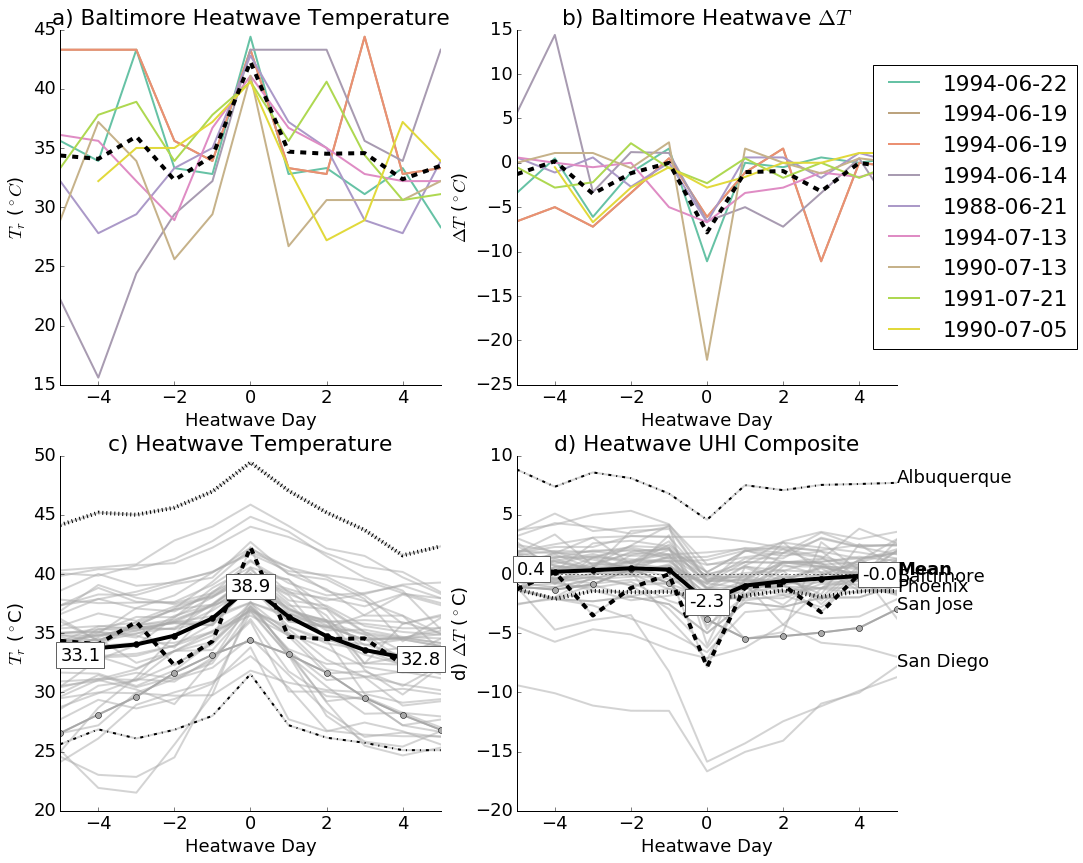

In [55]:
plt.figure(figsize=[15,14])
bmorec = 'black'
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))

plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel(r'$\Delta T$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
plt.legend(heatwaves.index, loc = 'right', bbox_to_anchor=(1.5, 0.5))

# i = 0
# for date in heatwaves.index: 
#     if ~np.isnan(compositeUHI[i][10]): 
# #         if i ==0 : 
# #             plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
# #         elif i ==3: 
# #             plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
# #         elif i ==7: 
# #             plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
# #         else: 
#         plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
# #     else: 
# #         plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

#     i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9], 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel(r'd) $\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][5],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][5],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][5],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Phoenix'][5],'Phoenix', color = 'k')
plt.text(5,compositeUHIDF.loc['San Jose'][5],'San Jose', color = 'k')

plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(results_filepath+ 'hwcompositeTMAX.pdf',bbox_inches='tight')

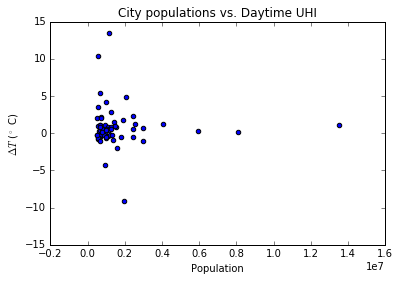

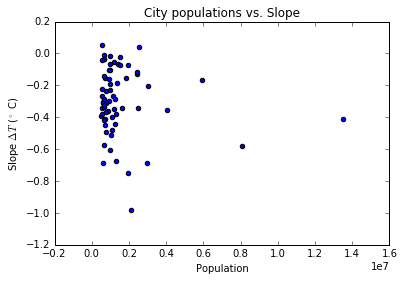

In [23]:
# scatterplot of UHI vs. population
atlas = pd.read_csv('data/world_cities.csv').set_index('city')
atlas = atlas[(atlas['country'] == 'United States of America') & (atlas['pop']>100000)]
atlas = atlas.sort_values('pop').drop_duplicates('city_ascii', keep='last', )

plt.scatter(atlas.loc[results_df.index]['pop'], results_df['Mean UHI'])
plt.xlabel('Population')
plt.ylabel('$\Delta T$ ($^\circ$ C)')
plt.title('City populations vs. Daytime UHI')

plt.figure()
plt.scatter(atlas.loc[results_df.index]['pop'], results_df['Slope'])
plt.xlabel('Population')
plt.ylabel('Slope $\Delta T$ ($^\circ$ C)')
plt.title('City populations vs. Slope')

In [28]:
paired_df.shape

(69, 10)